# **Prediksi Kualitas udara di 5 Wilayah Jakarta**

# Library

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import matplotlib.dates as mdates
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import LSTM, Dense, Reshape, Bidirectional, Dropout, BatchNormalization

# Load Data

In [ ]:
quality_air_1 = pd.read_csv("https://raw.githubusercontent.com/ejapten/CP-Quality-Air/refs/heads/main/raw_data/2010_feb2025_JKT_Quality_Air.csv")
quality_air_2 = pd.read_csv("https://raw.githubusercontent.com/ejapten/CP-Quality-Air/refs/heads/main/raw_data/2024_mar20265_JKT_Quality_Air.csv")

In [ ]:
quality_air_1

,tanggal,stasiun,pm25,pm10,so2,co,o3,no2,max,critical,categori
0,2010-01-01,DKI1 (Bunderan HI),NaN,60.0,4.0,73.0,27.0,14.0,73.0,CO,SEDANG
1,2010-01-02,DKI1 (Bunderan HI),NaN,32.0,2.0,16.0,33.0,9.0,33.0,O3,BAIK
2,2010-01-03,DKI1 (Bunderan HI),NaN,27.0,2.0,19.0,20.0,9.0,27.0,PM10,BAIK
3,2010-01-04,DKI1 (Bunderan HI),NaN,22.0,2.0,16.0,15.0,6.0,22.0,PM10,BAIK
4,2010-01-05,DKI1 (Bunderan HI),NaN,25.0,2.0,17.0,15.0,8.0,25.0,PM10,BAIK
...,...,...,...,...,...,...,...,...,...,...,...
5168,2025-02-24,DKI1 (Bunderan HI),55.0,42.0,28.0,15.0,14.0,28.0,55.0,PM25,SEDANG
5169,2025-02-25,DKI1 (Bunderan HI),66.0,47.0,38.0,19.0,5.0,31.0,66.0,PM25,SEDANG
5170,2025-02-26,DKI1 (Bunderan HI),57.0,45.0,30.0,17.0,7.0,30.0,57.0,PM25,SEDANG
5171,2025-02-27,DKI1 (Bunderan HI),85.0,54.0,36.0,26.0,12.0,50.0,85.0,PM25,SEDANG


In [ ]:
quality_air_2

,periode_data,bulan,tanggal,stasiun,pm_sepuluh,pm_duakomalima,sulfur_dioksida,karbon_monoksida,ozon,nitrogen_dioksida,max,parameter_pencemar_kritis,kategori
0,202401,1,21,DKI3 Jagakarsa,51.0,65.0,45.0,9.0,8.0,79.0,79.0,NaN,SEDANG
1,202401,1,22,DKI3 Jagakarsa,27.0,34.0,45.0,5.0,8.0,56.0,56.0,NaN,SEDANG
2,202401,1,23,DKI3 Jagakarsa,NaN,52.0,46.0,6.0,9.0,51.0,52.0,PM25,SEDANG
3,202401,1,24,DKI3 Jagakarsa,46.0,65.0,46.0,8.0,9.0,38.0,65.0,PM25,SEDANG
4,202401,1,25,DKI3 Jagakarsa,37.0,55.0,47.0,7.0,11.0,28.0,55.0,PM25,SEDANG
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,202503,3,26,DKI5 Kebon Jeruk,25.0,77.0,19.0,10.0,44.0,11.0,77.0,PM25,SEDANG
2276,202503,3,27,DKI5 Kebon Jeruk,23.0,73.0,21.0,12.0,39.0,10.0,73.0,PM25,SEDANG
2277,202503,3,28,DKI5 Kebon Jeruk,16.0,52.0,17.0,7.0,32.0,11.0,52.0,PM25,SEDANG
2278,202503,3,29,DKI5 Kebon Jeruk,10.0,20.0,19.0,3.0,24.0,10.0,24.0,O3,BAIK


In [ ]:
# Cek missing value
def check_missing_value (df):
  df = df.isnull().sum()
  return df

# Cek duplikat data
def check_duplicated(df):
  df = df.duplicated().sum()
  return df

# Cek tipe data
def check_data_type(df):
  df = df.info()

In [ ]:
mv_1 = check_missing_value(quality_air_1)
mv_2 = check_missing_value(quality_air_2)
duplicated_1 = check_duplicated(quality_air_1)
duplicated_2 = check_duplicated(quality_air_2)

print("tipe data quality air 1\n")
tipe_data_1 = check_data_type(quality_air_1)
print("--------------------------------------")
print("tipe data quality air 2\n")
tipe_data_2 = check_data_type(quality_air_2)
print("--------------------------------------")
print("missing value quality air 1\n", mv_1)
print("--------------------------------------")
print("\nmissing value quality air 2\n", mv_2)
print("--------------------------------------")
print("\nduplikat data quality air 1\n", duplicated_1)
print("--------------------------------------")
print("\nduplikat data quality air 2\n", duplicated_2)

tipe data quality air 1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5173 entries, 0 to 5172
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tanggal   5173 non-null   object 
 1   stasiun   5173 non-null   object 
 2   pm25      1146 non-null   float64
 3   pm10      4957 non-null   float64
 4   so2       4985 non-null   float64
 5   co        5005 non-null   float64
 6   o3        4964 non-null   float64
 7   no2       4974 non-null   float64
 8   max       5160 non-null   float64
 9   critical  5059 non-null   object 
 10  categori  5173 non-null   object 
dtypes: float64(7), object(4)
memory usage: 444.7+ KB
--------------------------------------
tipe data quality air 2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2280 entries, 0 to 2279
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   periode_data       

In [ ]:
# Inisialisasi  kolom numerik dan object
numeric_cols1 = quality_air_1.select_dtypes(include='number').columns
numeric_cols2 = quality_air_2.select_dtypes(include='number').columns

object_cols1 = [col for col in quality_air_1.select_dtypes(include='object').columns if col != 'tanggal']
object_cols2 = quality_air_2.select_dtypes(include='object').columns

# Fungsi melihat outliers di kolom numerik
def check_outliers(df, numeric_columns, max_cols_per_row=8):
  num_cols = len(numeric_columns)
  num_rows = math.ceil(num_cols / max_cols_per_row)

  plt.figure(figsize=(20, 4 * num_rows))
  for i, column in enumerate(numeric_columns):
        plt.subplot(num_rows, max_cols_per_row, i + 1)
        sns.boxplot(y=df[column])
        plt.title(column)
  plt.tight_layout()
  plt.show()

# Fungsi melihat distribusi pada kolom numerik
def plot_numeric_distribution(df, numeric_columns, max_cols_per_row=4, kde=True, bins=30):
  num_cols = len(numeric_columns)
  num_rows = math.ceil(num_cols / max_cols_per_row)

  plt.figure(figsize=(5 * max_cols_per_row, 4 * num_rows))
  for i, column in enumerate(numeric_columns):
        plt.subplot(num_rows, max_cols_per_row, i + 1)
        sns.histplot(df[column], kde=kde, bins=bins, color='blue')
        plt.title(f'Distribusi: {column}')
        plt.xlabel(column)
        plt.ylabel('Frekuensi')
  plt.tight_layout()
  plt.show()

# Fungsi melihat distribusi pada kolom object
def plot_categorical_distribution(df, categorical_columns, max_cols_per_row=4):
  num_cols = len(categorical_columns)
  num_rows = math.ceil(num_cols / max_cols_per_row)

  plt.figure(figsize=(5 * max_cols_per_row, 4 * num_rows))
  for i, column in enumerate(categorical_columns):
        plt.subplot(num_rows, max_cols_per_row, i + 1)
        sns.countplot(data=df, x=column, hue=column, order=df[column].value_counts().index, palette="Set2", legend=False)
        plt.title(f'Distribusi: {column}')
        plt.xticks(rotation=45)
        plt.xlabel(column)
        plt.ylabel("Jumlah")
  plt.tight_layout()
  plt.show()


Melihat Outliers pada Data pertama



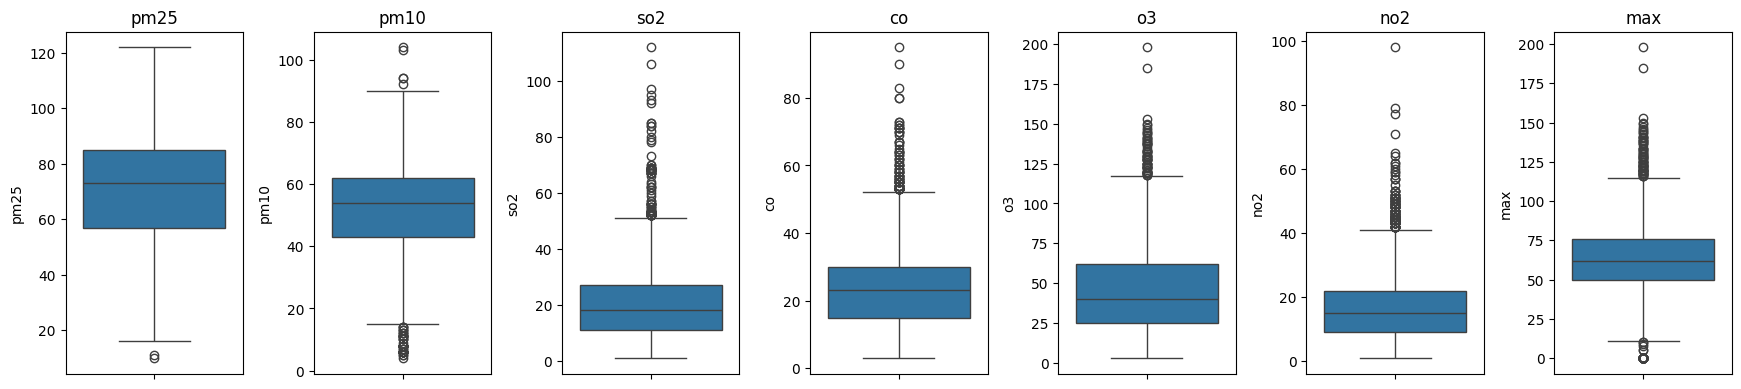

In [ ]:
# Apply
print("\nMelihat Outliers pada Data pertama\n")
check_outliers(quality_air_1, numeric_cols1)


Melihat Outliers pada Data kedua



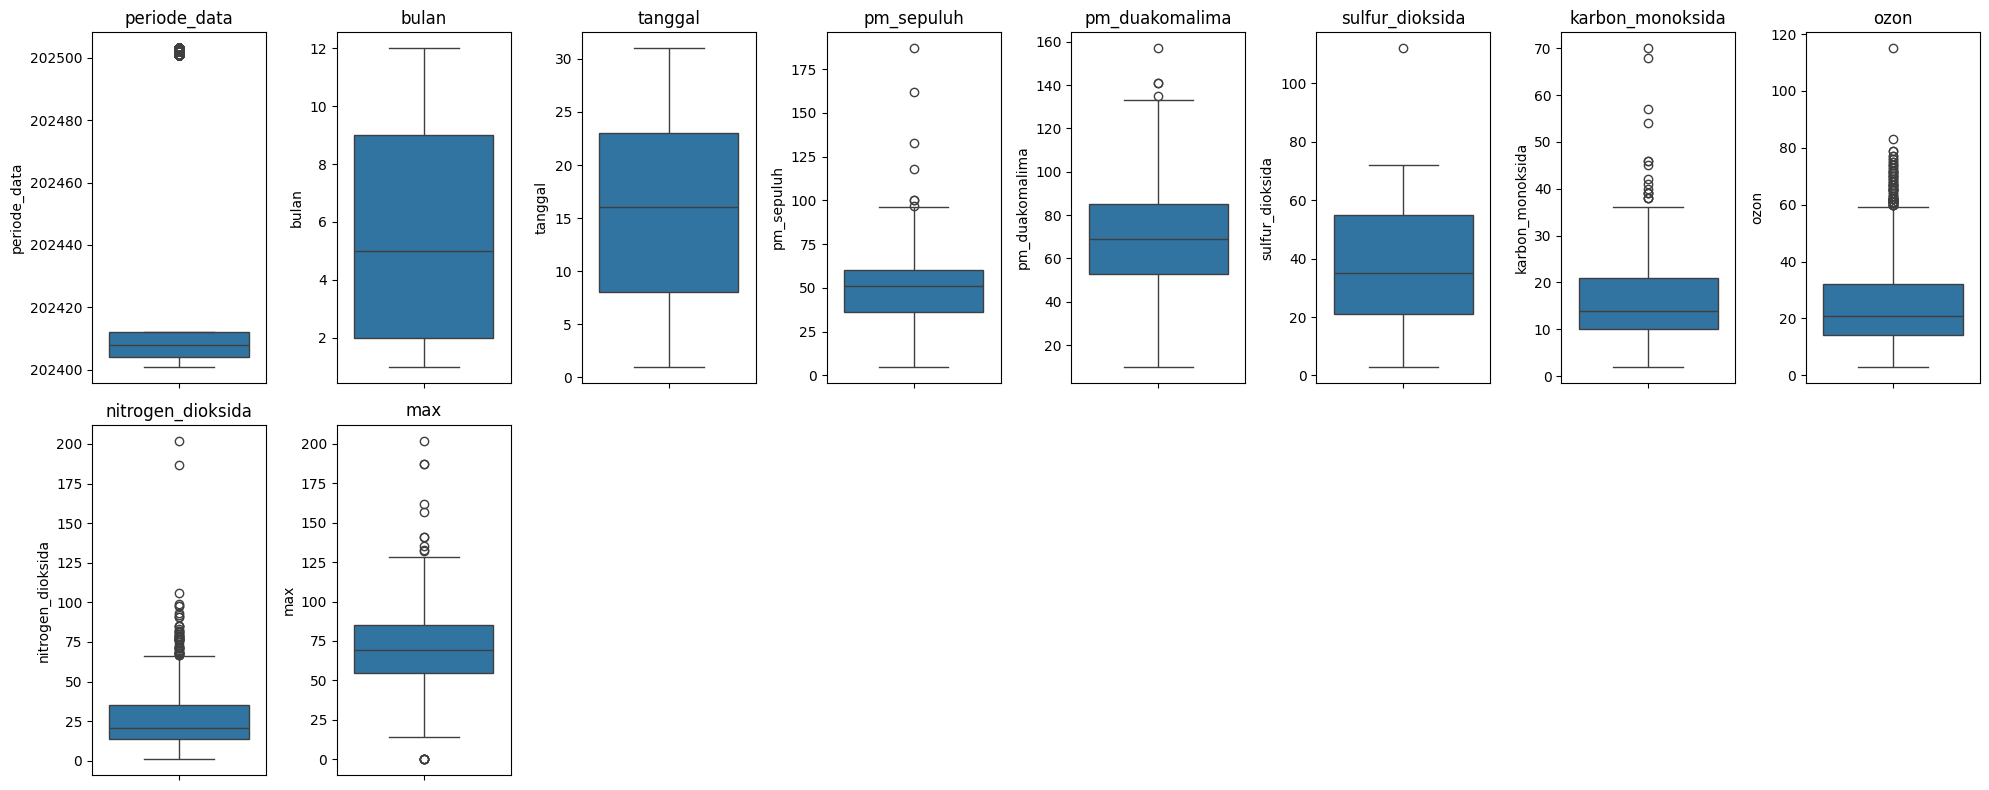

In [ ]:
# Apply
print("\nMelihat Outliers pada Data kedua\n")
check_outliers(quality_air_2, numeric_cols2)


Melihat distribusi numerik pada data 1



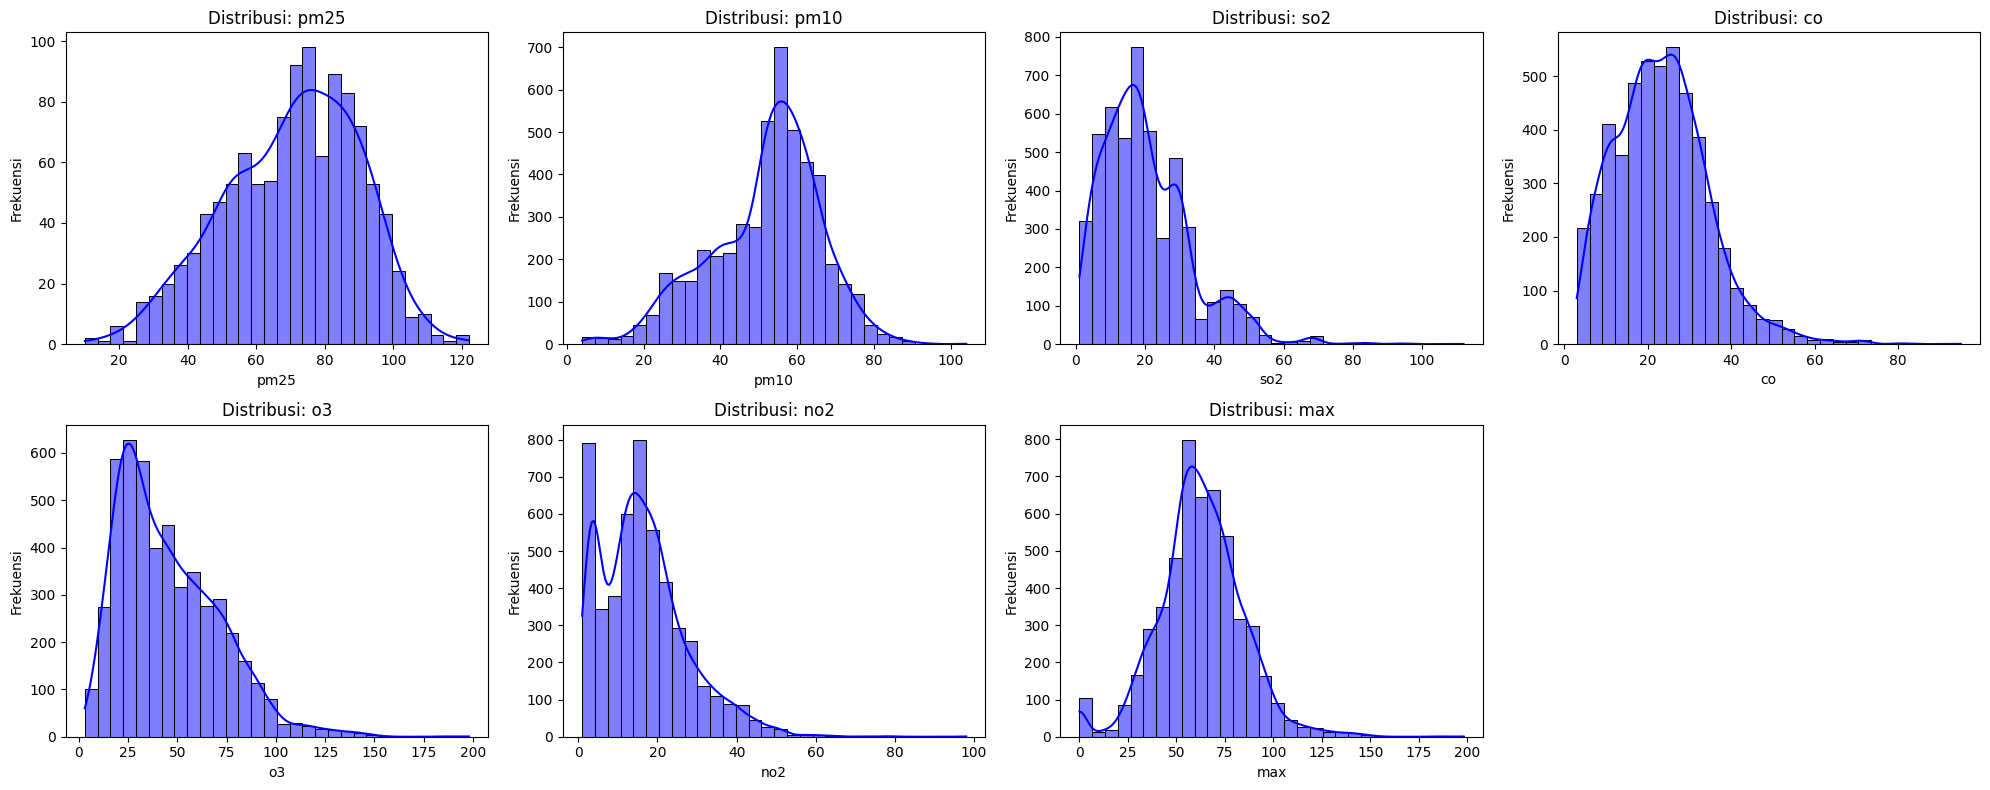

In [ ]:
print("\nMelihat distribusi numerik pada data 1\n")
plot_numeric_distribution(quality_air_1, numeric_cols1)


Melihat distribusi numerik pada data 2



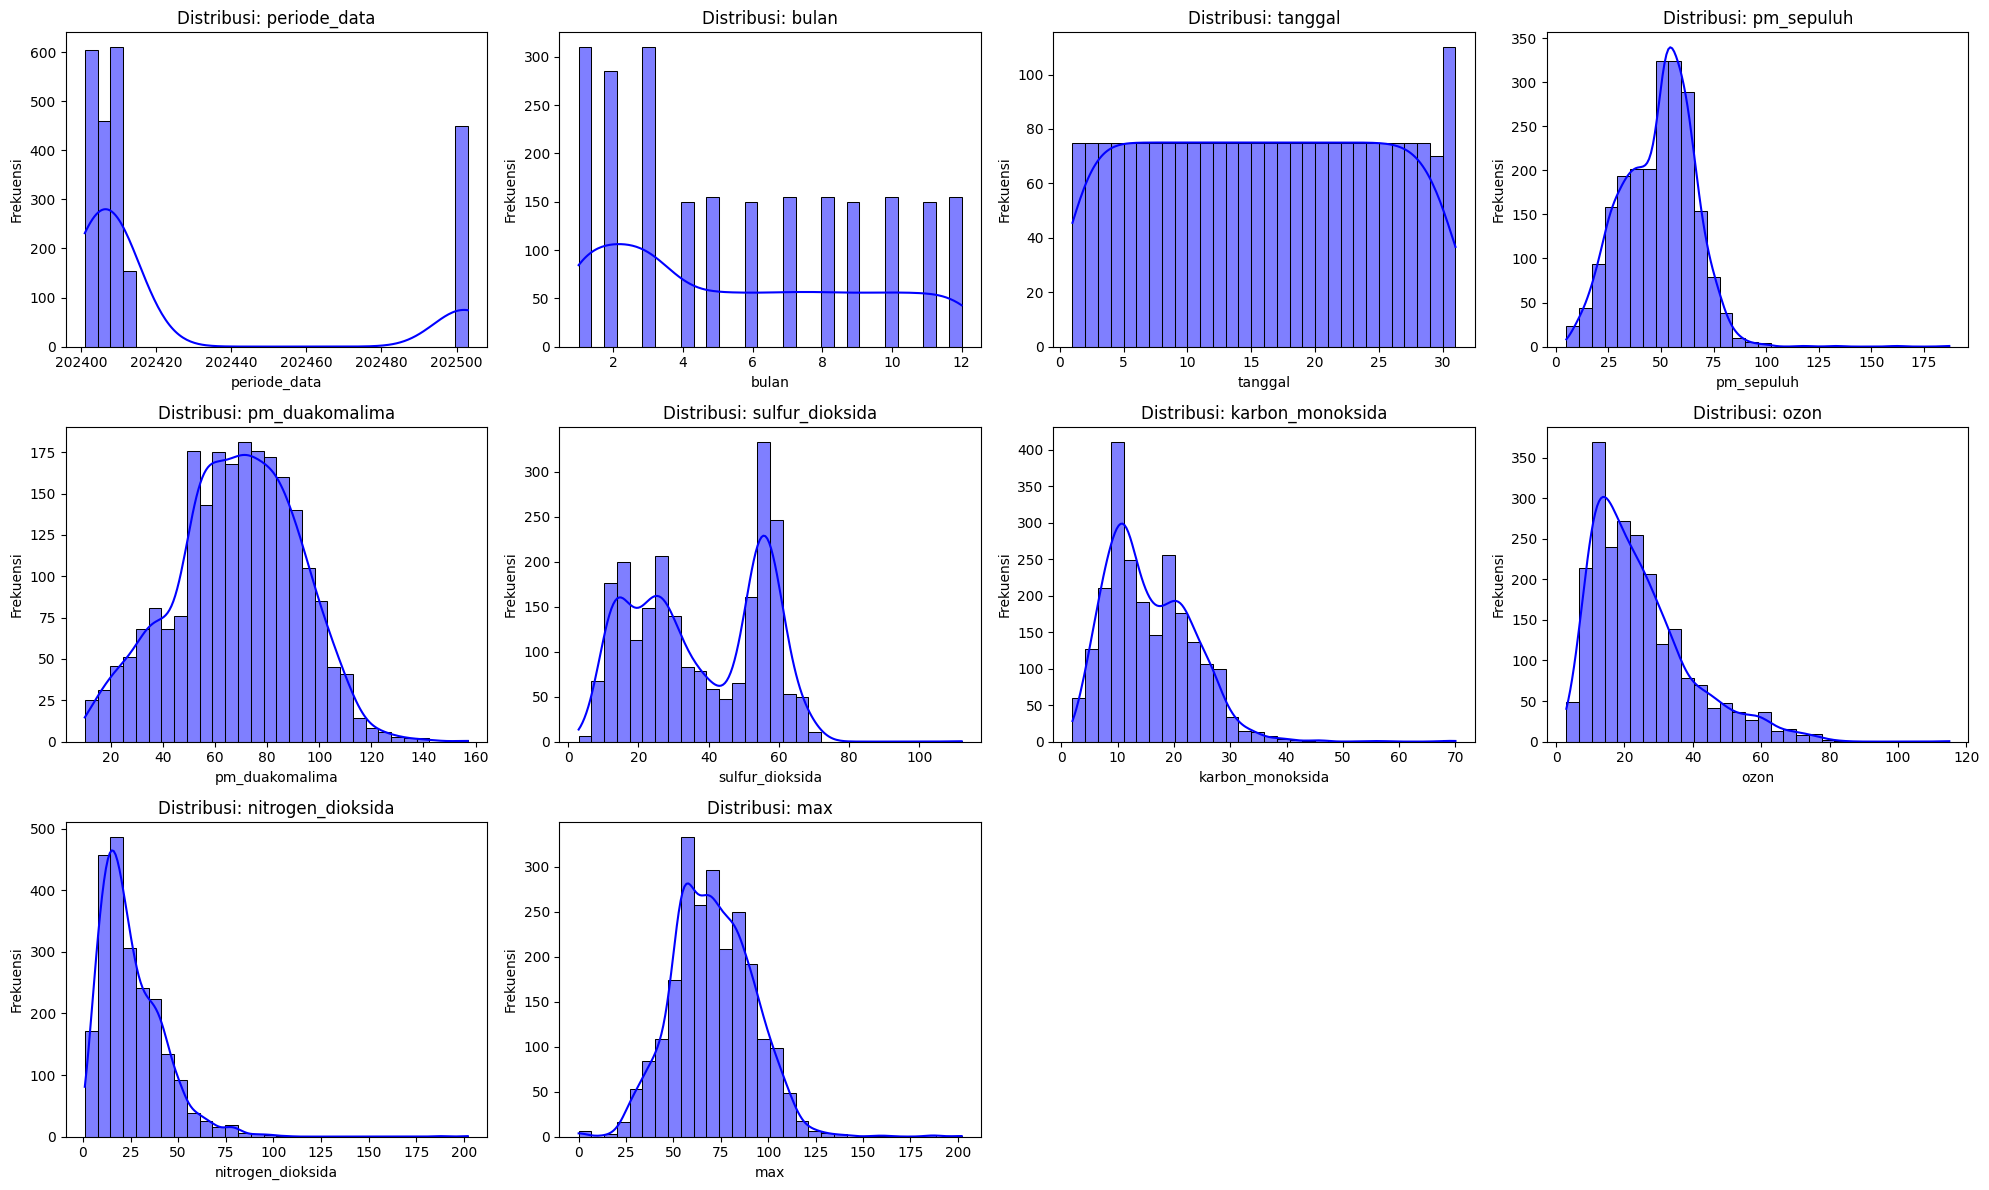

In [ ]:
print("\nMelihat distribusi numerik pada data 2\n")
plot_numeric_distribution(quality_air_2, numeric_cols2)


Melihat distribusi kategorikal pada data1



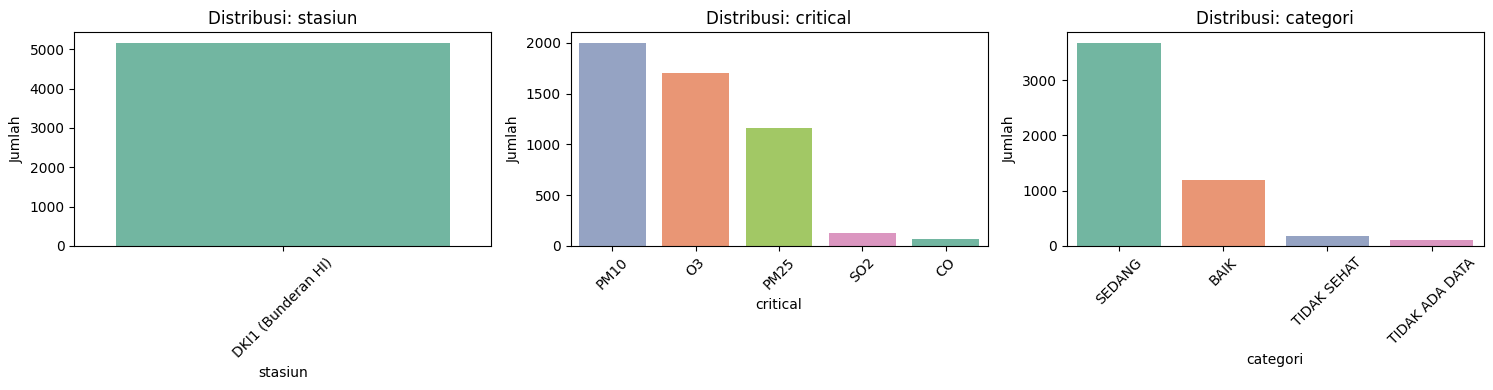

In [ ]:
print("\nMelihat distribusi kategorikal pada data1\n")
plot_categorical_distribution(quality_air_1, object_cols1)


Melihat distribusi kategorikal pada data 2



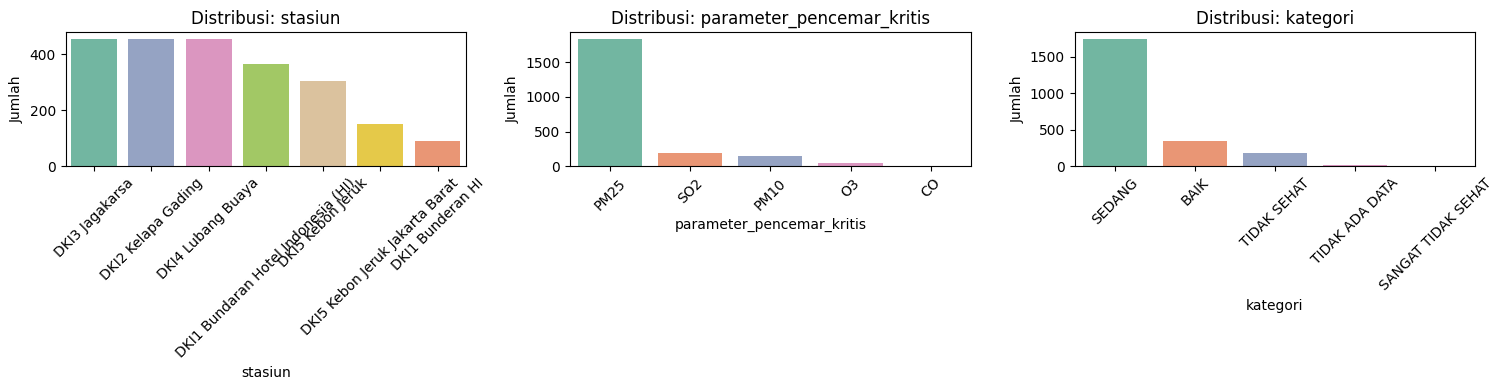

In [ ]:
print("\nMelihat distribusi kategorikal pada data 2\n")
plot_categorical_distribution(quality_air_2, object_cols2)

In [ ]:
print("\nDeskripsi Statistik pada Data 1\n")
quality_air_1.describe()


Deskripsi Statistik pada Data 1



,pm25,pm10,so2,co,o3,no2,max
count,1146.000000,4957.000000,4985.000000,5005.000000,4964.000000,4974.000000,5160.000000
mean,70.450262,51.849707,20.276429,23.422977,45.399678,16.587857,62.482946
std,19.517625,14.400174,12.900370,11.210342,25.742079,10.902702,22.030396
min,10.000000,4.000000,1.000000,3.000000,3.000000,1.000000,0.000000
25%,57.000000,43.000000,11.000000,15.000000,25.000000,9.000000,50.000000
50%,73.000000,54.000000,18.000000,23.000000,40.000000,15.000000,62.000000
75%,85.000000,62.000000,27.000000,30.000000,62.000000,22.000000,76.000000
max,122.000000,104.000000,112.000000,95.000000,198.000000,98.000000,198.000000


In [ ]:
print("\nDeskripsi Statistik pada Data 2\n")
quality_air_2.describe()


Deskripsi Statistik pada Data 2



,periode_data,bulan,tanggal,pm_sepuluh,pm_duakomalima,sulfur_dioksida,karbon_monoksida,ozon,nitrogen_dioksida,max
count,2280.000000,2280.000000,2280.000000,2147.000000,2249.000000,2245.000000,2246.000000,2251.000000,2227.000000,2275.000000
mean,202425.359649,5.622807,15.712719,48.746157,67.927523,37.255679,15.597952,24.632163,25.482263,70.636044
std,38.140494,3.595718,8.794291,16.992853,23.601952,18.065799,7.549744,14.525218,16.805853,21.166017
min,202401.000000,1.000000,1.000000,5.000000,10.000000,3.000000,2.000000,3.000000,1.000000,0.000000
25%,202404.000000,2.000000,8.000000,36.000000,53.000000,21.000000,10.000000,14.000000,14.000000,55.000000
50%,202408.000000,5.000000,16.000000,51.000000,69.000000,35.000000,14.000000,21.000000,21.000000,69.000000
75%,202412.000000,9.000000,23.000000,60.000000,85.000000,55.000000,21.000000,32.000000,35.000000,85.000000
max,202503.000000,12.000000,31.000000,187.000000,157.000000,112.000000,70.000000,115.000000,202.000000,202.000000


In [ ]:
# Tampilkan semua baris dengan nilai critical yang missing + semua kolom pada data 1
missing_critical_rows = quality_air_1[quality_air_1['critical'].isnull()]
missing_critical_rows


,tanggal,stasiun,pm25,pm10,so2,co,o3,no2,max,critical,categori
175,2010-06-25,DKI1 (Bunderan HI),NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,TIDAK ADA DATA
215,2010-08-04,DKI1 (Bunderan HI),NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,TIDAK ADA DATA
304,2010-11-01,DKI1 (Bunderan HI),NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,TIDAK ADA DATA
419,2011-02-24,DKI1 (Bunderan HI),NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,TIDAK ADA DATA
420,2011-02-25,DKI1 (Bunderan HI),NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,TIDAK ADA DATA
...,...,...,...,...,...,...,...,...,...,...,...
3649,2019-12-29,DKI1 (Bunderan HI),NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,TIDAK ADA DATA
4463,2023-03-22,DKI1 (Bunderan HI),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TIDAK ADA DATA
4464,2023-03-23,DKI1 (Bunderan HI),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TIDAK ADA DATA
4465,2023-03-24,DKI1 (Bunderan HI),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TIDAK ADA DATA


In [ ]:
# Tampilkan semua baris dengan nilai critical yang missing + semua kolom pada data 2
missing_critical_rows2 = quality_air_2[quality_air_2['parameter_pencemar_kritis'].isnull()]
print(missing_critical_rows2)

      periode_data  bulan  tanggal             stasiun  pm_sepuluh  \
0           202401      1       21      DKI3 Jagakarsa        51.0   
1           202401      1       22      DKI3 Jagakarsa        27.0   
162         202401      1       30  DKI2 Kelapa Gading        51.0   
237         202401      1       12      DKI3 Jagakarsa        37.0   
239         202401      1       14      DKI3 Jagakarsa        42.0   
244         202401      1       19      DKI3 Jagakarsa        32.0   
245         202401      1       20      DKI3 Jagakarsa        32.0   
299         202403      3        1  DKI2 Kelapa Gading        53.0   
369         202403      3        4      DKI3 Jagakarsa        43.0   
370         202403      3        5      DKI3 Jagakarsa        44.0   
375         202403      3       10      DKI3 Jagakarsa        54.0   
376         202403      3       11      DKI3 Jagakarsa        51.0   
380         202403      3       15      DKI3 Jagakarsa        23.0   
381         202403  

In [ ]:
print("\nNilai Missing Value pada kolom polutan pada data 1\n")
# Daftar kolom polutan
polutan_cols = ['pm25', 'pm10', 'so2', 'co', 'o3', 'no2']
# Filter baris di mana SEMUA kolom polutan adalah NaN
baris_kosong_semua_polutan = quality_air_1[quality_air_1[polutan_cols].isnull().all(axis=1)]
# Tampilkan hasil
baris_kosong_semua_polutan



Nilai Missing Value pada kolom polutan pada data 1



,tanggal,stasiun,pm25,pm10,so2,co,o3,no2,max,critical,categori
175,2010-06-25,DKI1 (Bunderan HI),NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,TIDAK ADA DATA
215,2010-08-04,DKI1 (Bunderan HI),NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,TIDAK ADA DATA
304,2010-11-01,DKI1 (Bunderan HI),NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,TIDAK ADA DATA
419,2011-02-24,DKI1 (Bunderan HI),NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,TIDAK ADA DATA
420,2011-02-25,DKI1 (Bunderan HI),NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,TIDAK ADA DATA
...,...,...,...,...,...,...,...,...,...,...,...
3649,2019-12-29,DKI1 (Bunderan HI),NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,TIDAK ADA DATA
4463,2023-03-22,DKI1 (Bunderan HI),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TIDAK ADA DATA
4464,2023-03-23,DKI1 (Bunderan HI),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TIDAK ADA DATA
4465,2023-03-24,DKI1 (Bunderan HI),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TIDAK ADA DATA


In [ ]:
print("\nNilai Missing Value pada kolom polutan pada data 2\n")
# Daftar kolom polutan
polutan_cols = ['pm_sepuluh',	'pm_duakomalima',	'sulfur_dioksida',	'karbon_monoksida',	'ozon',	'nitrogen_dioksida']
# Filter baris di mana SEMUA kolom polutan adalah NaN
baris_kosong_semua_polutan2 = quality_air_2[quality_air_2[polutan_cols].isnull().all(axis=1)]
# Tampilkan hasil
print(baris_kosong_semua_polutan2)



Nilai Missing Value pada kolom polutan pada data 2

      periode_data  bulan  tanggal             stasiun  pm_sepuluh  \
411         202403      3       22   DKI4 Lubang Buaya         NaN   
585         202402      2       19  DKI2 Kelapa Gading         NaN   
612         202402      2       28   DKI4 Lubang Buaya         NaN   
704         202409      9        2   DKI4 Lubang Buaya         NaN   
795         202405      5        2   DKI4 Lubang Buaya         NaN   
1613        202411     11       28      DKI3 Jagakarsa         NaN   
2028        202502      2       16  DKI2 Kelapa Gading         NaN   
2085        202502      2       16   DKI4 Lubang Buaya         NaN   
2086        202502      2       17   DKI4 Lubang Buaya         NaN   
2132        202503      3       11  DKI2 Kelapa Gading         NaN   
2235        202503      3       17   DKI4 Lubang Buaya         NaN   

      pm_duakomalima  sulfur_dioksida  karbon_monoksida  ozon  \
411              NaN              NaN    

### Melihat Data pada kolom PM2.5


In [ ]:
"""quality_air_1"""
#Salin kolom 'tanggal' dan 'pm25' ke DataFrame baru
df1_new = quality_air_1[['tanggal', 'pm25']].copy()
#Konversi kolom 'tanggal' menjadi tipe data datetime
df1_new['tanggal'] = pd.to_datetime(df1_new['tanggal'])

"""quality_air_2"""
quality_air_2_copy = quality_air_2.copy()

date_components = pd.DataFrame({
    'year': quality_air_2['periode_data'].astype(str).str[:4],
    'month': quality_air_2['bulan'],
    'day': quality_air_2['tanggal']
})

# Konversi ke datetime. 'errors=coerce' akan mengubah baris yang gagal menjadi NaT
quality_air_2_copy['tanggal_gabungan'] = pd.to_datetime(date_components, errors='coerce')


# Buat DataFrame baru
df2_new =quality_air_2_copy[['tanggal_gabungan', 'pm_duakomalima']].copy()

# Ganti nama kolom agar sesuai
df2_new.rename(columns={
    'tanggal_gabungan': 'tanggal',
    'pm_duakomalima': 'pm25'
}, inplace=True)

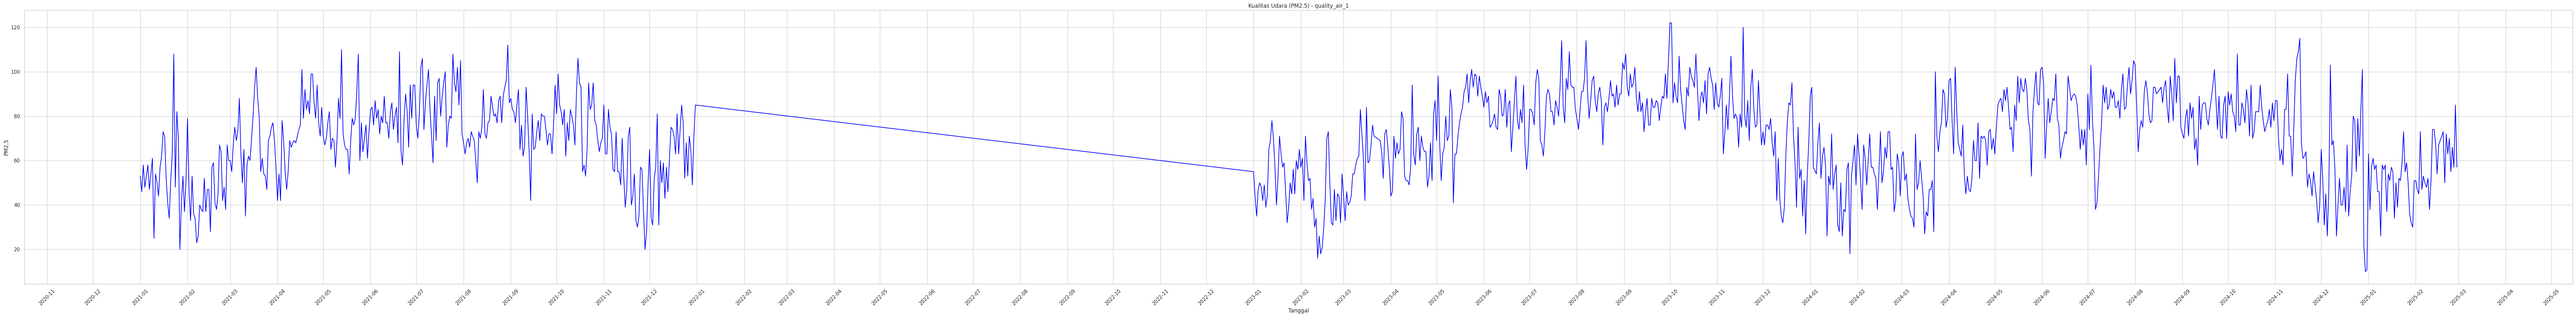

In [ ]:


# Set style
sns.set(style='whitegrid')

# Buat plot
plt.figure(figsize=(80, 10))
sns.lineplot(data=df1_new, x='tanggal', y='pm25', color='blue')

# Format sumbu X: tahun-bulan
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # tampilkan setiap bulan
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate label agar lebih rapi
plt.xticks(rotation=45)

# Judul dan label
plt.title('Kualitas Udara (PM2.5) - quality_air_1')
plt.xlabel('Tanggal')
plt.ylabel('PM2.5')
plt.tight_layout()
plt.show()

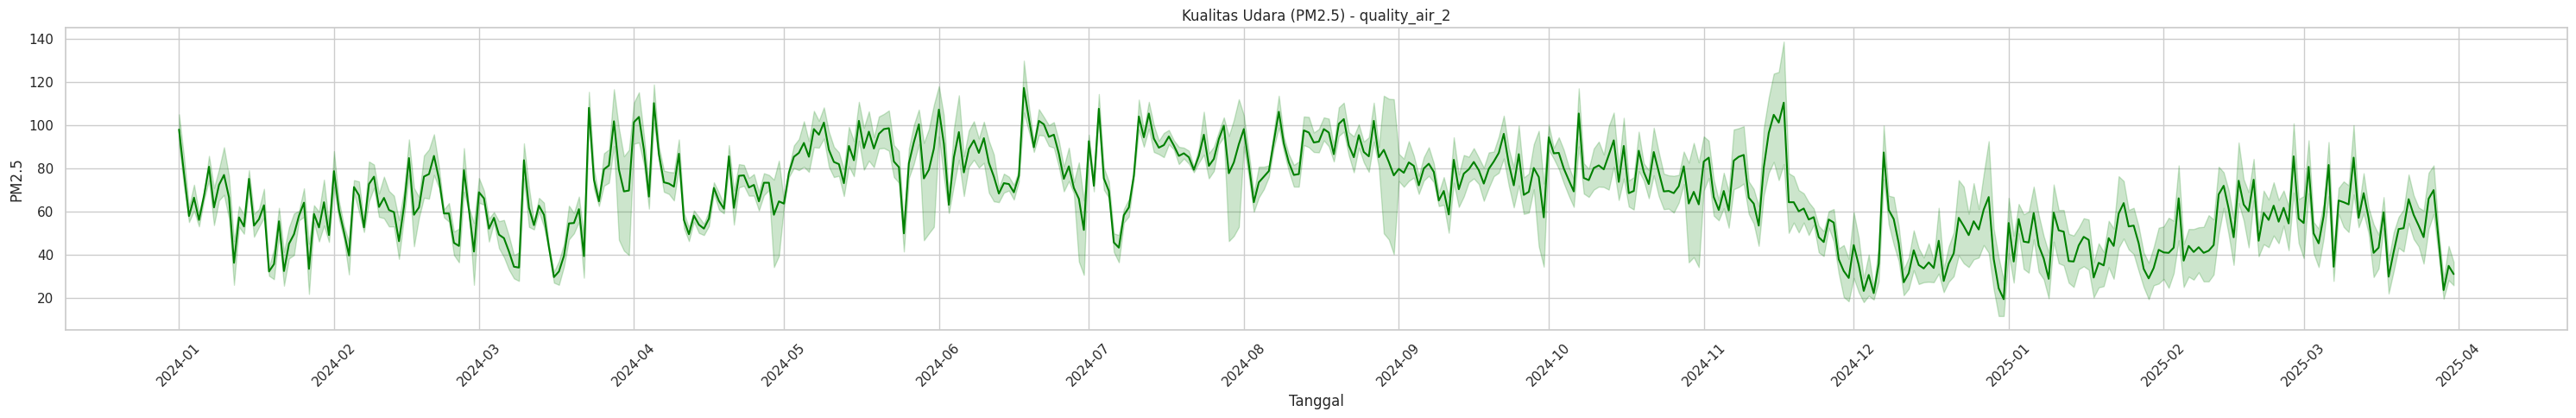

In [ ]:
# Set style
sns.set(style='whitegrid')

# Visualisasi line chart untuk df2_new
plt.figure(figsize=(30, 5))
sns.lineplot(data=df2_new, x='tanggal', y='pm25', color='green')
# Format sumbu X: tahun-bulan
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # tampilkan setiap bulan
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate label agar lebih rapi
plt.xticks(rotation=45)

plt.title('Kualitas Udara (PM2.5) - quality_air_2')
plt.xlabel('Tanggal')
plt.ylabel('PM2.5')
plt.tight_layout()
plt.show()

**df_1 dan df_2**

- Periode Januari-Maret cenderung lebih rendah dan akan naik lagi pada April
- Pada April dan Mei akan naik
- pada Juni hingga oktober akan cenderung tinggi
- Pada November hingga Desember akan menurun

**Hal diatas dipengaruhi oleh musim, dimana musim kemarau Juni-Oktober polusi PM2.5 cenderung lebih tinggi dan musim hujan Desember-Maret cenderung lebih rendah**


===========================================================================================================


**Dalam df1_new, data untuk tahun 2022 hilang atau kosong pada semua kolom, sehingga menyebabkan:**

- Ketimpangan waktu dalam data historis.

- Kehilangan informasi penting dalam pola tahunan.

===========================================================================================================

**Pada df1_new atau quality_air_1 Karena PM2.5 memiliki pola musiman (seasonal) yang cukup stabil, maka:**

**1. Tahun 2022 akan diisi dengan data dari tahun 2021.**

- Alasan: 2021 dan 2022 berdekatan secara waktu dan diasumsikan memiliki pola musim yang serupa.

- Keuntungan: Mengisi kekosongan tanpa menambahkan noise yang tidak sesuai.

**2.  Setelah itu, akan memiliki data lengkap dari :.**

- Tahun 2020 diisi dengan 2021 karena sama pada era covid

- Tahun 2019 diisi dengan data 2023 karena era normal


*penambahan data dibantu dengan noise

**Tujuan :
Memperkuat jumlah data historis tanpa kehilangan pola musiman alami.**





# Preprocessing

In [ ]:
# Membuat salinan Untuk Preprocessing
df_1 = quality_air_1.copy() # Dataset pertama
df_2 = quality_air_2.copy() # Dataset kedua

In [ ]:
"""Membuat data sintetis untuk tahun 2022 berdasarkan data asli tahun 2023,
dengan menambahkan noise  agar tidak identik, namun tetap realistis.
Ini dilakukan karena data tahun 2022 tidak tersedia."""

# Copy df_1
df_1_copy = df_1.copy()
# kolom tanggal jadi datetime
df_1_copy['tanggal'] = pd.to_datetime(df_1_copy['tanggal'])
# Pilih data tahun 2021 sebagai sumber
df_2023_original = df_1_copy[df_1_copy['tanggal'].dt.year == 2023].copy()
# Salin hanya nilai polutannya
df_2023_values = df_2023_original[['pm25', 'pm10', 'so2', 'co', 'o3', 'no2']].copy()

# Geser tanggal ke tahun 2022
df_2022_augmented = df_2023_original.copy()
df_2022_augmented['tanggal'] = df_2022_augmented['tanggal'] + pd.DateOffset(years=1)

# Kolom polutan
pollutants = ['pm25', 'pm10', 'so2', 'co', 'o3', 'no2']

# Tambahkan noise hanya pada salinan 2022
for col in pollutants:
    noise1 = np.random.normal(0, 0.75, size=len(df_2022_augmented))
    noise2 = np.random.normal(0, 0.75, size=len(df_2022_augmented))
    total_noise = noise1 + noise2

    df_2022_augmented[col] = df_2023_values[col] + total_noise
    df_2022_augmented[col] = df_2022_augmented[col].clip(lower=0)

print(df_2022_augmented.head())


        tanggal             stasiun       pm25       pm10        so2  \
4383 2024-01-01  DKI1 (Bunderan HI)  52.812644  44.410595  48.743928   
4384 2024-01-02  DKI1 (Bunderan HI)  43.419963  31.127571  51.669562   
4385 2024-01-03  DKI1 (Bunderan HI)  35.936651  31.348362  48.250486   
4386 2024-01-04  DKI1 (Bunderan HI)  46.927007  30.837010  53.751601   
4387 2024-01-05  DKI1 (Bunderan HI)  51.453213  38.758082  49.115077   

             co         o3        no2   max critical categori  
4383   9.376151  24.682318   9.610034  55.0     PM25   SEDANG  
4384   8.675625  25.143827   8.355443  52.0      SO2   SEDANG  
4385   8.004468  11.890701   8.063000  49.0      SO2     BAIK  
4386   8.623286  14.979165   8.052443  53.0      SO2   SEDANG  
4387  13.253902  27.163085  12.192085  50.0     PM25     BAIK  


In [ ]:
"""Membandingkan mean dan standard deviation polutan antara data asli
tahun 2021 dan data tahun 2022 hasil salinan dari 2021 yang telah
ditambahkan noise."""

# Daftar polutan
pollutants = ['pm25', 'pm10', 'so2', 'co', 'o3', 'no2']
# Hitung statistik tahun 2021
mean_2023 = df_2023_original[pollutants].mean()
std_2023 = df_2023_original[pollutants].std()
# Hitung statistik tahun 2022 hasil augmentasi
mean_2022 = df_2022_augmented[pollutants].mean()
std_2022 = df_2022_augmented[pollutants].std()
# Gabungkan ke dalam DataFrame
comparison_df = pd.DataFrame({
    'Mean 2023': mean_2023,
    'Std 2023': std_2023,
    'Mean 2022 (Augmented)': mean_2022,
    'Std 2022 (Augmented)': std_2022
})

# Tampilkan tabel perbandingan
print("\nPerbandingan Statistik Polutan (2023 vs Augmented 2022):\n")
print(comparison_df.round(2))



Perbandingan Statistik Polutan (2023 vs Augmented 2022):

      Mean 2023  Std 2023  Mean 2022 (Augmented)  Std 2022 (Augmented)
pm25      73.71     20.13                  73.75                 20.17
pm10      51.67     12.34                  51.64                 12.33
so2       43.96      5.29                  43.95                  5.41
co        10.40      2.75                  10.39                  2.98
o3        25.84      8.12                  25.86                  8.15
no2       24.82      8.64                  24.79                  8.75


In [ ]:
"""mengisi nilai kosong (NaN) pada kolom pm25 untuk data tahun 2019 dan 2020, dengan cara mengambil nilai pm25 dari tanggal
yang sama (bulan-hari) pada 2021 dan 2023 (2021 salin untuk 2020 zaman covid, 2024 salin untuk 2019 normal), kemudian menambahkan noise agar nilainya bervariasi dan tidak identik.
Tujuannya adalah agar data historis lebih lengkap dan realistis untuk analisis atau pelatihan model."""

# Pastikan kolom tanggal dalam format datetime
df_1_copy2 = df_1.copy()
df_1_copy2['tanggal'] = pd.to_datetime(df_1_copy2['tanggal'])

# Filter hanya data tahun 2019-2020
df_2019_2020_filled = df_1_copy2[df_1_copy2['tanggal'].dt.year.isin([2019, 2020])].copy()

# Ambil data pm25 dari tahun 2021 dan 2024 sebagai sumber
df_source = df_1_copy2[df_1_copy2['tanggal'].dt.year.isin([2024, 2021])].copy()

# Buat mapping dari bulan-hari (MM-DD) ke nilai pm25 sebagai sumber
source_dict = df_source.set_index(df_source['tanggal'].dt.strftime('%m-%d'))['pm25'].to_dict()

# Fungsi untuk mengisi pm25 kosong dengan nilai dari source + noise
def fill_pm25(row):
    if pd.isna(row['pm25']):
        key = row['tanggal'].strftime('%m-%d')
        if key in source_dict:
            noise = np.random.normal(0, 1.0)  # noise ~ N(0, 1)
            value = source_dict[key] + noise
            return max(value, 0)  # hindari nilai negatif
    return row['pm25']

# Terapkan fungsi hanya
df_2019_2020_filled['pm25'] = df_2019_2020_filled.apply(fill_pm25, axis=1)

# Cek hasil
print(df_2019_2020_filled[['tanggal', 'pm25']].head())


        tanggal       pm25
3287 2019-01-01  89.802091
3288 2019-01-02  91.413886
3289 2019-01-03  58.840598
3290 2019-01-04        NaN
3291 2019-01-05  52.229199


Sejauh ini mempunyai 4 dataset untuk dianalisis:
1. df_1 = data asli quality_air_1 (2010-2024)
2. df_2 = data asli quality_air_2 (2024-2025)
3. df_2022_augmented = data tahun 2022 hasil duplikasi data 2021 dengan tambahan noise untuk variasi.
4. df_2019_2020_filled = data tahun 2019–2020 dari quality_air_1 yang sebelumnya memiliki nilai pm25 kosong, kini telah diisi dengan nilai dari tahun 2021 dan 2023 (tanggal yang sama) ditambah noise agar lebih bervariasi.

In [ ]:
# Check mv pada df baru
print("\nMissin value pada data df_2022_augmented\n", check_missing_value(df_2022_augmented))
print("\nMissing value pada df_2017_2020_filled\n", check_missing_value(df_2019_2020_filled))


Missin value pada data df_2022_augmented
 tanggal      0
stasiun      0
pm25         4
pm10         4
so2          8
co          13
o3           4
no2          4
max          4
critical     4
categori     0
dtype: int64

Missing value pada df_2017_2020_filled
 tanggal      0
stasiun      0
pm25         6
pm10        18
so2         17
co          17
o3          18
no2         26
max          0
critical    10
categori     0
dtype: int64


In [ ]:
"""Membuat fungsi Menghapus Missing value dengan median pada data dengan missing value kurang dari 200 pada kolom polutan"""

# Fungsi menghapus MV dengan median
def isi_mv_dengan_median(df_target, daftar_kolom):
    print(f"--- Memulai imputasi median untuk DataFrame ---")
    for kolom in daftar_kolom:
        if kolom in df_target.columns:
            # Hitung median hanya untuk kolom saat ini
            median_nilai = df_target[kolom].median()

            # Isi missing values secara in-place
            df_target[kolom].fillna(median_nilai, inplace=True)

            print(f"Missing values di kolom '{kolom}' setelah imputasi median: {df_target[kolom].isnull().sum()}")
        else:
            print(f"Peringatan: Kolom '{kolom}' tidak ditemukan dalam DataFrame.")
    print(f"--- Imputasi median selesai ---")
    return df_target

#  kolom polutan pada df_1 (mv < 200)
cols_polutan_df1 = ['pm10', 'so2', 'co', 'o3', 'no2']
# Kolom polutan pada df_2 yang akan dihapus MV nya
cols_polutan_df2 = ['pm_sepuluh',	'pm_duakomalima',	'sulfur_dioksida',	'karbon_monoksida',	'ozon',	'nitrogen_dioksida']
# Kolom polutan pada df_2017_2020_filled
cols_polutan_df_2019_2020_filled = ['pm25', 'pm10', 'so2', 'co', 'o3', 'no2']


In [ ]:
"""Implementasi menghapus missing value"""

# Mengapus missing value pada kolom pm2.5 (mv > 4000) di df_1
df_1.dropna(subset=['pm25'], inplace=True)
# Hapus baris di mana SEMUA kolom polutan bernilai NaN
df_2 = df_2.dropna(subset=cols_polutan_df2, how='all')
df_2019_2020_filled = df_2019_2020_filled.dropna(subset=cols_polutan_df_2019_2020_filled, how='all')
#  Mengganti nilai missing value pada kolom polutan yang semua baris pada kolom polutan tidak bernlai NaN menggunakan median
df_1 = isi_mv_dengan_median(df_1, cols_polutan_df1)
df_2 = isi_mv_dengan_median(df_2, cols_polutan_df2)
df_2017_2020_filled = isi_mv_dengan_median(df_2019_2020_filled, cols_polutan_df_2019_2020_filled)

--- Memulai imputasi median untuk DataFrame ---
Missing values di kolom 'pm10' setelah imputasi median: 0
Missing values di kolom 'so2' setelah imputasi median: 0
Missing values di kolom 'co' setelah imputasi median: 0
Missing values di kolom 'o3' setelah imputasi median: 0
Missing values di kolom 'no2' setelah imputasi median: 0
--- Imputasi median selesai ---
--- Memulai imputasi median untuk DataFrame ---
Missing values di kolom 'pm_sepuluh' setelah imputasi median: 0
Missing values di kolom 'pm_duakomalima' setelah imputasi median: 0
Missing values di kolom 'sulfur_dioksida' setelah imputasi median: 0
Missing values di kolom 'karbon_monoksida' setelah imputasi median: 0
Missing values di kolom 'ozon' setelah imputasi median: 0
Missing values di kolom 'nitrogen_dioksida' setelah imputasi median: 0
--- Imputasi median selesai ---
--- Memulai imputasi median untuk DataFrame ---
Missing values di kolom 'pm25' setelah imputasi median: 0
Missing values di kolom 'pm10' setelah imputasi me

<ipython-input-132-86f7d54d02c0>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_target[kolom].fillna(median_nilai, inplace=True)
<ipython-input-132-86f7d54d02c0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target[kolom].fillna(median_nilai, inplace=True)


In [ ]:
""" Mengisi nilai pada kolom  parameter_pencemar_kritis di df_2  dan critical di df_2017_2020_filled berdasarkan nilai polutan di kolom max"""

cols_polutan2 = ['pm_sepuluh',	'pm_duakomalima',	'sulfur_dioksida',	'karbon_monoksida',	'ozon',	'nitrogen_dioksida']
cols_polutan_df_2019_2020_filled = ['pm25', 'pm10', 'so2', 'co', 'o3', 'no2']

# Fungsi untuk mencari nama polutan yang nilainya sama dengan max di baris tersebut
def isi_pencemar_kritis(row, polutan_cols):
    for col in polutan_cols:
        if row[col] == row['max']:
            return col
    return np.nan

# Terapkan hanya ke baris yang masih kosong
df_2['parameter_pencemar_kritis'] = df_2.apply(
    lambda row: isi_pencemar_kritis(row, cols_polutan2) if pd.isna(row['parameter_pencemar_kritis']) else row['parameter_pencemar_kritis'],
    axis=1
)

df_2019_2020_filled['critical'] = df_2019_2020_filled.apply(
    lambda row: isi_pencemar_kritis(row, cols_polutan_df_2019_2020_filled) if pd.isna(row['critical']) else row['critical'],
    axis=1
)

<ipython-input-134-a3a27d25ce36>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['parameter_pencemar_kritis'] = df_2.apply(
<ipython-input-134-a3a27d25ce36>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2019_2020_filled['critical'] = df_2019_2020_filled.apply(


In [ ]:
"""Menghilangkan outliers dengan transformasi akar kuadrat dan winsorizing"""

# 1. handle outliers dengan transformasi akar kuadrat
def transform_sqrt_columns_inplace(df_input, columns_to_transform):
    transformed_count = 0
    for col in columns_to_transform:
        if col in df_input.columns:
            if pd.api.types.is_numeric_dtype(df_input[col]):
                # Cek apakah ada nilai negatif di kolom
                if (df_input[col] < 0).any():
                    print(f"Peringatan: Kolom '{col}' berisi nilai negatif. "
                          f"Transformasi akar kuadrat tidak dapat diterapkan pada nilai negatif. "
                          f"Kolom ini akan DILEWATI.")
                    continue # Lewati transformasi untuk kolom ini

                # Menerapkan transformasi akar kuadrat secara langsung pada DataFrame masukan
                df_input[col] = np.sqrt(df_input[col])
                print(f"Kolom '{col}' telah berhasil ditransformasi dengan akar kuadrat (in-place).")
                transformed_count += 1
            else:
                print(f"Peringatan: Kolom '{col}' bukan tipe numerik dan akan dilewati.")
        else:
            print(f"Peringatan: Kolom '{col}' tidak ditemukan dalam DataFrame.")

    if transformed_count == 0:
        print("Tidak ada kolom yang valid yang ditransformasi.")

    return df_input

# 2. Handle Outliers dengan winsorizing
# Tentukan persentil untuk batas bawah dan atas
lower_percentile = 0.02
upper_percentile = 0.98

def winsorize_dataframe_columns(df, columns, lower_p, upper_p):
    df_winsorized = df.copy() # Buat salinan
    for col in columns:
        if col in df_winsorized.columns and pd.api.types.is_numeric_dtype(df_winsorized[col]):
            # Hitung batas bawah dan atas berdasarkan persentil kolom tersebut
            lower_bound = df_winsorized[col].quantile(lower_p)
            upper_bound = df_winsorized[col].quantile(upper_p)

            # Terapkan clipping (Winsorizing)
            df_winsorized[col] = df_winsorized[col].clip(lower=lower_bound, upper=upper_bound)
            print(f"Kolom '{col}' di-winsorize dengan batas bawah: {lower_bound:.2f} (P{int(lower_p*100)}) dan batas atas: {upper_bound:.2f} (P{int(upper_p*100)}).")
        elif col not in df_winsorized.columns:
            print(f"Peringatan: Kolom '{col}' tidak ditemukan dalam DataFrame.")
        else:
            print(f"Peringatan: Kolom '{col}' bukan tipe numerik dan akan dilewati.")
    return df_winsorized

# Apply df_1 transformasi akar kuadrat
cols_polutan1 = ['pm25', 'pm10', 'so2', 'co', 'o3', 'no2']
df_1 = transform_sqrt_columns_inplace(df_1, cols_polutan1)
# Apply df_2 transformasi akar kuadrat
cols_polutan2 = ['pm_sepuluh',	'pm_duakomalima',	'sulfur_dioksida',	'karbon_monoksida',	'ozon',	'nitrogen_dioksida']
df_2 = transform_sqrt_columns_inplace(df_2, cols_polutan2)
# Apply df_2022_augmented transformasi akar kuadrat
cols_polutan_df_2022_augmented = ['pm25', 'pm10', 'so2', 'co', 'o3', 'no2']
df_2022_augmented = transform_sqrt_columns_inplace(df_2022_augmented, cols_polutan_df_2022_augmented)
# Apply df_2019_2020_filled transformasi akar kuadrat
cols_polutan_df_2019_2020_filled = ['pm25', 'pm10', 'so2', 'co', 'o3', 'no2']
df_2019_2020_filled = transform_sqrt_columns_inplace(df_2019_2020_filled, cols_polutan_df_2019_2020_filled)
# Apply pada df_1 winsorizing
df_1_winsorized = winsorize_dataframe_columns(df_1, cols_polutan1, lower_percentile, upper_percentile)
# Apply pada df_2 winsorizing
df_2_winsorized = winsorize_dataframe_columns(df_2, cols_polutan2, lower_percentile, upper_percentile)
# Apply pada df_2022_augmented winsorizing
df_2022_augmented_winsorized = winsorize_dataframe_columns(df_2022_augmented,cols_polutan_df_2022_augmented, lower_percentile, upper_percentile)
# Apply pada df_2017_2020_filled winsorizing
df_2019_2020_winsorized = winsorize_dataframe_columns(df_2019_2020_filled, cols_polutan_df_2019_2020_filled, lower_percentile, upper_percentile)


Kolom 'pm25' telah berhasil ditransformasi dengan akar kuadrat (in-place).
Kolom 'pm10' telah berhasil ditransformasi dengan akar kuadrat (in-place).
Kolom 'so2' telah berhasil ditransformasi dengan akar kuadrat (in-place).
Kolom 'co' telah berhasil ditransformasi dengan akar kuadrat (in-place).
Kolom 'o3' telah berhasil ditransformasi dengan akar kuadrat (in-place).
Kolom 'no2' telah berhasil ditransformasi dengan akar kuadrat (in-place).
Kolom 'pm_sepuluh' telah berhasil ditransformasi dengan akar kuadrat (in-place).
Kolom 'pm_duakomalima' telah berhasil ditransformasi dengan akar kuadrat (in-place).
Kolom 'sulfur_dioksida' telah berhasil ditransformasi dengan akar kuadrat (in-place).
Kolom 'karbon_monoksida' telah berhasil ditransformasi dengan akar kuadrat (in-place).
Kolom 'ozon' telah berhasil ditransformasi dengan akar kuadrat (in-place).
Kolom 'nitrogen_dioksida' telah berhasil ditransformasi dengan akar kuadrat (in-place).
Kolom 'pm25' telah berhasil ditransformasi dengan akar

<ipython-input-135-48a2ebfc55b4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[col] = np.sqrt(df_input[col])


In [ ]:
""" Menggantti nama variabel dan modifikasi variabel tanggal """

# Fungsi Mengganti nama variabel
def rename_columns(df, columns_name):
    df = df.rename(columns=columns_name)
    return df

# Fungsi menggabungkan kolom tanggal
def combine_date(df, column_year, column_month, column_day, tanggal='tanggal'):
    df["tahun"] = df[column_year].astype(str).str[:4]
    df["bulan"] = df[column_month].astype(int).astype(str).str.zfill(2)
    df["day"] = df[column_day].astype(int).astype(str).str.zfill(2)
    df[tanggal] = df['tahun'] + '-' + df['bulan'] + '-' + df['day']

    # Menghapus kolom sementara dan kolom asli yang tidak diperlukan lagi
    return df.drop(columns=['tahun', 'bulan', 'day', column_year])

# Rename kolom polutan
column_mapping1 = {
    "pm_sepuluh": "PM10",
    "pm_duakomalima": "PM2.5",
    "sulfur_dioksida": "SO2",
    "karbon_monoksida": "CO",
    "ozon": "O3",
    "nitrogen_dioksida": "NO2",
    "parameter_pencemar_kritis": "critical",
    "kategori": "categori"
}
column_mapping2 = {
    'pm10': 'PM10',
    'pm25': 'PM2.5',
    'so2': 'SO2',
    'co': 'CO',
    'o3': 'O3',
    'no2': 'NO2'
}

# Menerapkan perubahan nama kolom
df_1_winsorized =  rename_columns(df_1_winsorized, column_mapping2)
df_2_winsorized= rename_columns(df_2_winsorized, column_mapping1)
df_2022_augmented_winsorized =rename_columns(df_2022_augmented_winsorized, column_mapping2)
df_2019_2020_winsorized= rename_columns(df_2019_2020_winsorized, column_mapping2)

# Menggabungkan kolom tanggal pada Dataset 2
df_2_winsorized = combine_date(df_2_winsorized, "periode_data", "bulan", "tanggal")

In [ ]:
df_2_winsorized

,tanggal,stasiun,PM10,PM2.5,SO2,CO,O3,NO2,max,critical,categori
0,2024-01-21,DKI3 Jagakarsa,7.141428,8.062258,6.708204,3.000000,2.828427,8.246211,79.0,nitrogen_dioksida,SEDANG
1,2024-01-22,DKI3 Jagakarsa,5.196152,5.830952,6.708204,2.236068,2.828427,7.483315,56.0,nitrogen_dioksida,SEDANG
2,2024-01-23,DKI3 Jagakarsa,7.141428,7.211103,6.782330,2.449490,3.000000,7.141428,52.0,PM25,SEDANG
3,2024-01-24,DKI3 Jagakarsa,6.782330,8.062258,6.782330,2.828427,3.000000,6.164414,65.0,PM25,SEDANG
4,2024-01-25,DKI3 Jagakarsa,6.082763,7.416198,6.855655,2.645751,3.316625,5.291503,55.0,PM25,SEDANG
...,...,...,...,...,...,...,...,...,...,...,...
2275,2025-03-26,DKI5 Kebon Jeruk,5.000000,8.774964,4.358899,3.162278,6.633250,3.316625,77.0,PM25,SEDANG
2276,2025-03-27,DKI5 Kebon Jeruk,4.795832,8.544004,4.582576,3.464102,6.244998,3.162278,73.0,PM25,SEDANG
2277,2025-03-28,DKI5 Kebon Jeruk,4.000000,7.211103,4.123106,2.645751,5.656854,3.316625,52.0,PM25,SEDANG
2278,2025-03-29,DKI5 Kebon Jeruk,3.918709,4.472136,4.358899,2.000000,4.898979,3.162278,24.0,O3,BAIK


In [ ]:
# Mengganti nilai unik pada df_2_winsorized kolom critical
replacement_map = {
    'nitrogen_dioksida': 'NO2',
    'pm_duakomalima': 'PM25'
}
# apply
df_2_winsorized['critical'] = df_2_winsorized['critical'].replace(replacement_map)

In [ ]:
# Ganti nama stasiun agar seragam
df_2_winsorized['stasiun'] = df_2_winsorized['stasiun'].replace({
    'DKI1 Bundaran Hotel Indonesia (HI)': 'DKI 1 : Bundaran HI',
    'DKI1 Bunderan HI' : 'DKI 1 : Bundaran HI',
    'DKI2 Kelapa Gading' : 'DKI 2 : Kelapa Gading',
    'DKI3 Jagakarsa': 'DKI 3 : Jagakarsa',
    'DKI4 Lubang Buaya' : 'DKI 4 : Lubang Buaya',
    'DKI5 Kebon Jeruk Jakarta Barat': 'DKI : 5 Kebon Jeruk',
    'DKI5 Kebon Jeruk': 'DKI 5 : Kebon Jeruk'})

df_1_winsorized['stasiun'] = df_1_winsorized['stasiun'].replace({
    'DKI1 (Bunderan HI)': 'DKI 1 : Bundaran HI'})

df_2022_augmented_winsorized['stasiun'] = df_2022_augmented_winsorized['stasiun'].replace({
    'DKI1 (Bunderan HI)': 'DKI 1 : Bundaran HI'})

df_2019_2020_winsorized['stasiun'] = df_2019_2020_winsorized['stasiun'].replace({
    'DKI1 (Bunderan HI)': 'DKI 1 : Bundaran HI'})

In [ ]:
# Konversi tipe data kolom tanggal menjadi date time dan gabungkan semua df
list_of_dfs = [df_1_winsorized, df_2_winsorized, df_2022_augmented_winsorized, df_2019_2020_winsorized]

for df in list_of_dfs:
    # pd.to_datetime aman digunakan bahkan jika beberapa kolom sudah datetime
    df['tanggal'] = pd.to_datetime(df['tanggal'], errors='coerce')

#  Gabungkan semua DataFrame menjadi satu
# ignore_index=True akan membuat index baru yang berurutan untuk DataFrame gabungan
df_combined = pd.concat(list_of_dfs, ignore_index=False)
df_combined.sort_values(by='tanggal', inplace=True)
df_combined.reset_index(drop=True, inplace=True)

In [ ]:
# Buat salinan agar df asli setelah penggabungan tidak beruban dan digunakan untuk proses pemisahan data berdasaarkan stasiun/daerah
quality_air = df_combined.copy()

In [ ]:
# Hapus nilai MV pada kolom polutan dengan median
cols_polutan_qa = ['PM2.5',	'PM10',	'SO2',	'CO',	'O3',	'NO2']
quality_air = isi_mv_dengan_median(quality_air, cols_polutan_qa)
# Hapus nilai Max dan critical dengan polutan konsentrasiyang terbesar
rows_with_missing_values = quality_air['max'].isnull()
max_values_to_fill = quality_air.loc[rows_with_missing_values, cols_polutan_qa].max(axis=1)
critical_pollutants_to_fill = quality_air.loc[rows_with_missing_values, cols_polutan_qa].idxmax(axis=1)
quality_air.loc[rows_with_missing_values, 'max'] = max_values_to_fill
quality_air.loc[rows_with_missing_values, 'critical'] = critical_pollutants_to_fill

# Hapus duplikat
quality_air= quality_air.drop_duplicates(keep='first')

--- Memulai imputasi median untuk DataFrame ---
Missing values di kolom 'PM2.5' setelah imputasi median: 0
Missing values di kolom 'PM10' setelah imputasi median: 0
Missing values di kolom 'SO2' setelah imputasi median: 0
Missing values di kolom 'CO' setelah imputasi median: 0
Missing values di kolom 'O3' setelah imputasi median: 0
Missing values di kolom 'NO2' setelah imputasi median: 0
--- Imputasi median selesai ---


<ipython-input-132-86f7d54d02c0>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_target[kolom].fillna(median_nilai, inplace=True)


In [ ]:
print("Pemeriksaan nilai hilang:\n")
print(quality_air.isnull().sum())

print("\nPemeriksaan nilai duplikat:")
print(quality_air.duplicated().sum())

Pemeriksaan nilai hilang:

tanggal     0
stasiun     0
PM2.5       0
PM10        0
SO2         0
CO          0
O3          0
NO2         0
max         0
critical    9
categori    0
dtype: int64

Pemeriksaan nilai duplikat:
0


In [ ]:
# Fitur untuk model
kolom_polutan = ['PM2.5', 'PM10', 'SO2', 'CO', 'O3', 'NO2']
# Kolom stasiun akan di one hot encoding
df_model = pd.get_dummies(quality_air, columns=['stasiun'], prefix='stasiun', dtype=int)
# Kolom tanggal akan dijadkan index
df_model = df_model.set_index('tanggal')
# buang kolom yang tidak perlu untuk inpur model
df_model = df_model.drop(columns=['max', 'critical', 'categori'])

In [ ]:
df_model

,PM2.5,PM10,SO2,CO,O3,NO2,stasiun_DKI 1 : Bundaran HI,stasiun_DKI 2 : Kelapa Gading,stasiun_DKI 3 : Jagakarsa,stasiun_DKI 4 : Lubang Buaya,stasiun_DKI 5 : Kebon Jeruk,stasiun_DKI : 5 Kebon Jeruk
tanggal,,,,,,,,,,,,
2019-01-01,9.476397,5.385165,3.872983,2.236068,6.928203,3.605551,1,0,0,0,0,0
2019-01-02,9.561061,4.898979,4.123106,2.236068,6.928203,2.449490,1,0,0,0,0,0
2019-01-03,7.670763,4.751557,4.000000,2.236068,5.385165,2.449490,1,0,0,0,0,0
2019-01-04,8.589282,6.164414,4.242641,2.828427,4.898979,3.605551,1,0,0,0,0,0
2019-01-05,7.226977,6.082763,5.385165,4.000000,6.928203,4.000000,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-31,4.898979,4.795832,4.123106,2.645751,3.741657,2.236068,0,0,0,1,0,0
2025-03-31,6.324555,4.898979,5.477226,2.645751,3.316625,2.828427,1,0,0,0,0,0
2025-03-31,5.477226,4.898979,3.162278,3.464102,3.316625,3.741657,0,0,1,0,0,0


In [ ]:
# Split daata
split_point = int(len(df_model) * 0.80)
# Slicing untuk mempertahankan urutan kronologis
train_df = df_model.iloc[:split_point]
test_df = df_model.iloc[split_point:]

print(f"\nJumlah data training: {len(train_df)}")
print(f"Jumlah data testing: {len(test_df)}")


Jumlah data training: 3349
Jumlah data testing: 838


In [ ]:
# Normalisasi
scaler = MinMaxScaler()

# Fit dan transform data training
train_df[kolom_polutan] = scaler.fit_transform(train_df[kolom_polutan])
# transform data testing menggunakan scaler yang sama
test_df[kolom_polutan] = scaler.transform(test_df[kolom_polutan])


<ipython-input-147-10553ea49fe0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[kolom_polutan] = scaler.fit_transform(train_df[kolom_polutan])
<ipython-input-147-10553ea49fe0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[kolom_polutan] = scaler.transform(test_df[kolom_polutan])


In [ ]:
def create_dataset(data, input_window, output_window, target_cols_indices):
    """
    Membuat dataset windowed untuk model time series.
    """
    X, y = [], []
    for i in range(len(data) - input_window - output_window + 1):
        # Input: N hari ke belakang
        input_seq = data[i:(i + input_window)]
        X.append(input_seq)

        # Output: M hari ke depan (hanya kolom polutan)
        output_seq = data[(i + input_window):(i + input_window + output_window), target_cols_indices]
        y.append(output_seq)

    return np.array(X), np.array(y)

In [ ]:
# Definisikan parameter window
input_window = 30
output_window = 15
jumlah_fitur = len(df_model.columns)
kolom_target_index = [df_model.columns.get_loc(col) for col in kolom_polutan]

# Ubah dataframe menjadi numpy array untuk diproses
train_data = train_df.values
test_data = test_df.values

# Buat dataset untuk training dan testing
X_train, y_train = create_dataset(train_data, input_window, output_window, kolom_target_index)
X_test, y_test = create_dataset(test_data, input_window, output_window, kolom_target_index)

# Model BILSTM

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import LSTM, Dense, Reshape, Bidirectional, Dropout, BatchNormalization

def build_model2(hp):
    model = Sequential(name="Advanced_BiLSTM_Model")

    # Mengambil parameter
    jumlah_fitur = X_train.shape[2]
    jumlah_polutan_target = y_train.shape[2]

    model.add(tf.keras.Input(shape=(input_window, jumlah_fitur)))

    # Tuning jumlah layer BiLSTM (sekarang bisa sampai 3 layer)
    hp_num_bilstm_layers = hp.Int('num_bilstm_layers', 2, 3)
    for i in range(hp_num_bilstm_layers):
        hp_units_bilstm = hp.Int(f'units_bilstm_{i+1}', min_value=64, max_value=192, step=32)
        # return_sequences=True untuk semua layer KECUALI yang terakhir di blok BiLSTM
        is_last_bilstm_layer = (i == hp_num_bilstm_layers - 1)

        # Gunakan Bidirectional yang membungkus LSTM
        model.add(Bidirectional(
            LSTM(units=hp_units_bilstm, return_sequences=not is_last_bilstm_layer)
        ))
        # BatchNormalization untuk menstabilkan
        model.add(BatchNormalization())
        # Dropout untuk regularisasi
        model.add(Dropout(rate=hp.Float(f'dropout_bilstm_{i+1}', 0.3, 0.5, step=0.1)))

    # Tuning jumlah layer Dense setelah BiLSTM
    hp_num_dense_layers = hp.Int('num_dense_layers', 1, 2)
    for i in range(hp_num_dense_layers):
        hp_units_dense = hp.Int(f'units_dense_{i+1}', min_value=64, max_value=256, step=64)
        model.add(Dense(units=hp_units_dense, activation='relu'))
        # Tambahkan BatchNormalization setelah Dense
        model.add(BatchNormalization())
        # Tambahkan Dropout setelah Dense
        model.add(Dropout(rate=hp.Float(f'dropout_dense_{i+1}', 0.3, 0.5, step=0.1)))

    # Output
    model.add(Dense(units=output_window * jumlah_polutan_target))
    model.add(Reshape((output_window, jumlah_polutan_target)))

    # Learning rate akan menurun seiring berjalannya waktu
    initial_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4])
    lr_schedule = ExponentialDecay(
        initial_learning_rate,
        decay_steps=10000,
        decay_rate=0.9)

    model.compile(optimizer=Adam(learning_rate=lr_schedule),
                  loss='mae',
                  metrics=['mse'])

    return model


In [ ]:
# Menyiapkan data
tuner2 = kt.Hyperband(
    build_model2,
    objective='val_loss',
    max_epochs=30,  # Maksimum epoch untuk satu model saat tuning
    factor=3,
    directory='hyperband_dir',
    project_name='air_quality_bilstm'
)

# Callback untuk menghentikan tuning lebih awal
stop_early_tuner = EarlyStopping(monitor='val_loss', patience=7)

print("\n--- Memulai Pencarian Hyperparameter (Hyperband) ---")
tuner2.search(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[stop_early_tuner]
)
print("\n--- Pencarian Hyperparameter Selesai ---")

# Hyperparameter terbaik
best_hps2 = tuner2.get_best_hyperparameters(num_trials=1)[0]
final_model2 = tuner2.hypermodel.build(best_hps2)
print(final_model2.summary())

Trial 90 Complete [00h 06m 23s]
val_loss: 0.1905047744512558

Best val_loss So Far: 0.1567842811346054
Total elapsed time: 04h 51m 15s

--- Pencarian Hyperparameter Selesai ---

--- Pencarian Hyperparameter Selesai ---


Model: "Advanced_BiLSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 30, 128)        │        38,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 90)             │         5,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 15, 6)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 326,170 (1.24 MB)

 Trainable params: 325,274 (1.24 MB)

 Non-trainable params: 896 (3.50 KB)

None


In [ ]:
# Menghitung bobot sample untuk data yang tidak seimbang

# nama kolom stasiun hasil one-hot encoding
stasiun_cols = [col for col in train_df.columns if 'stasiun_' in col]
# nama stasiun asli dari data training sebelum di-window
original_labels = train_df[stasiun_cols].idxmax(axis=1)

# Hitung bobot untuk setiap kelas stasiun
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(original_labels),
    y=original_labels
)
# Buat dictionary pemetaan dari nama kelas ke bobotnya
weight_dict = {label: weight for label, weight in zip(np.unique(original_labels), class_weights_array)}
print("Bobot Kelas yang Dihitung:", weight_dict)

""" Buat array sample bobot di X_train """
#one-hot vector stasiun dari timestep pertama setiap jendela
x_train_stations_ohe = X_train[:, 0, -len(stasiun_cols):]
# indeks kelas stasiun
x_train_station_indices = np.argmax(x_train_stations_ohe, axis=1)
# nama stasiun sesuai urutan one hot encoding
station_names_ordered = np.unique(original_labels)
# inisialisas indeks ke nama stasiun
x_train_station_names = [station_names_ordered[i] for i in x_train_station_indices]
# nama stasiun ke boobotnya untuk membuat array
sample_weights1 = np.array([weight_dict[name] for name in x_train_station_names])
sample_weights = np.repeat(sample_weights1[:, np.newaxis], output_window, axis=1)
print(f"Shape dari sample_weights berhasil dibuat: {sample_weights.shape}")


Bobot Kelas yang Dihitung: {'stasiun_DKI 1 : Bundaran HI': np.float64(0.3160924964605946), 'stasiun_DKI 2 : Kelapa Gading': np.float64(2.1746753246753245), 'stasiun_DKI 4 : Lubang Buaya': np.float64(2.196065573770492), 'stasiun_DKI : 3 Jagakarsa': np.float64(2.1746753246753245), 'stasiun_DKI : 5 Kebon Jeruk': np.float64(2.1676375404530743)}
Shape dari sample_weights berhasil dibuat: (3305, 15)


In [ ]:
# Siapkan callbacks untuk pelatihan final
final_checkpoint2 = ModelCheckpoint(filepath='model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
final_early_stopping2 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# Training
history_final2 = final_model2.fit(
    X_train, y_train,
    epochs=100, # Latih lebih lama untuk konvergensi
    batch_size=16,
    validation_data=(X_test, y_test),
    sample_weight=sample_weights, # Menggunakan bobot yang sudah dihitung
    callbacks=[final_checkpoint2, final_early_stopping2]
)

Epoch 1/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.6315 - mse: 1.2411
Epoch 1: val_loss improved from inf to 0.19324, saving model to model.keras
207/207 ━━━━━━━━━━━━━━━━━━━━ 28s 84ms/step - loss: 0.6308 - mse: 1.2400 - val_loss: 0.1932 - val_mse: 0.0593
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.3183 - mse: 0.5430
Epoch 2: val_loss improved from 0.19324 to 0.19062, saving model to model.keras
207/207 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - loss: 0.3181 - mse: 0.5424 - val_loss: 0.1906 - val_mse: 0.0564
Epoch 3/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.2180 - mse: 0.1816
Epoch 3: val_loss improved from 0.19062 to 0.17660, saving model to model.keras
207/207 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - loss: 0.2180 - mse: 0.1814 - val_loss: 0.1766 - val_mse: 0.0490
Epoch 4/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1867 - mse: 0.1133
Epoch 4: val_loss improved from 0.17660 to 0.17100, saving model to model.keras
207/207 ━━━━━━━━━━━━━━━━━

Kurva



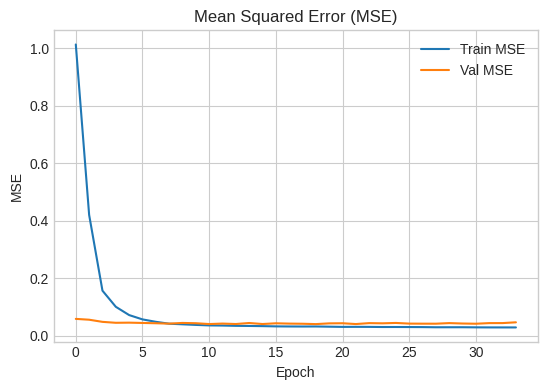


Score

--- Skor Akhir Model ---
Loss: 0.16212
Compile_metrics: 0.04122


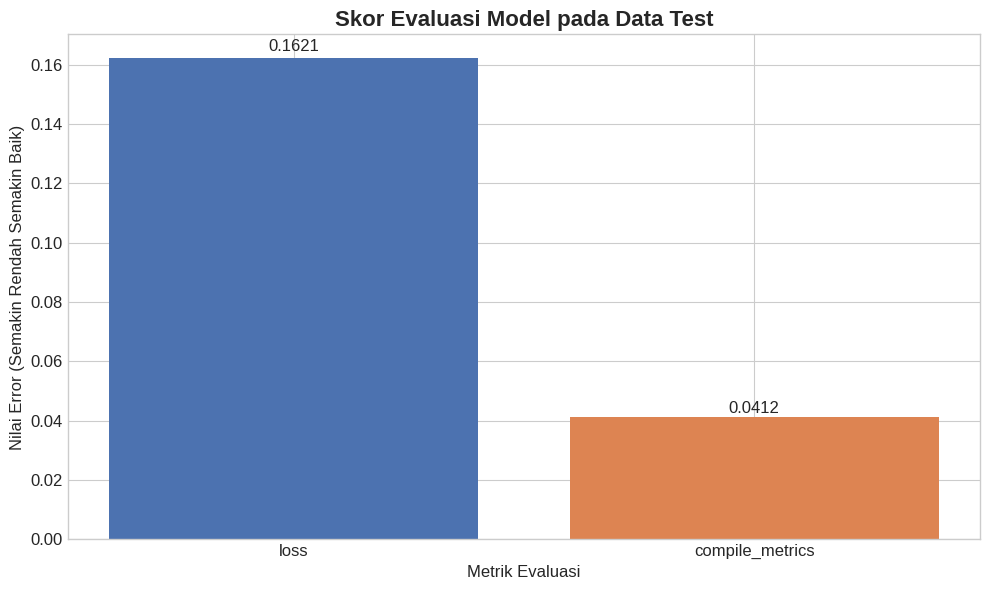

{'loss': 0.1621159315109253, 'compile_metrics': 0.04121777042746544}

In [ ]:
print("Kurva\n")
plot_training_history(history_final2.history)

print("\nScore")
evaluate_and_plot_metrics(final_model2, X_test, y_test)

# Evaluasi

In [ ]:
def plot_training_history(history, figsize=(16, 4)):
    plt.figure(figsize=figsize)
    # Plot MSE
    plt.subplot(1, 3, 3)
    plt.plot(history['mse'], label='Train MSE')
    plt.plot(history['val_mse'], label='Val MSE')
    plt.title('Mean Squared Error (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_and_plot_metrics(model, x_test, y_test):

    #Mengevaluasi model untuk mendapatkan skor
    scores = model.evaluate(x_test, y_test, verbose=0)

    # Membuat dictionary dari nama metrik dan skornya
    metric_names = model.metrics_names
    results = {name: score for name, score in zip(metric_names, scores)}

    print("\n--- Skor Akhir Model ---")
    for name, score in results.items():
        print(f"{name.capitalize()}: {score:.5f}")

    # Membuat Bar Chart dari hasil evaluasi
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(results.keys(), results.values(), color=['#4c72b0', '#dd8452', '#55a868'])

    # Menambahkan judul dan label
    ax.set_title('Skor Evaluasi Model pada Data Test', fontsize=16, fontweight='bold')
    ax.set_ylabel('Nilai Error (Semakin Rendah Semakin Baik)', fontsize=12)
    ax.set_xlabel('Metrik Evaluasi', fontsize=12)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    # Menambahkan nilai skor di atas setiap bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + (yval * 0.01), f'{yval:.4f}',
                va='bottom', ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()

    return results

Kurva



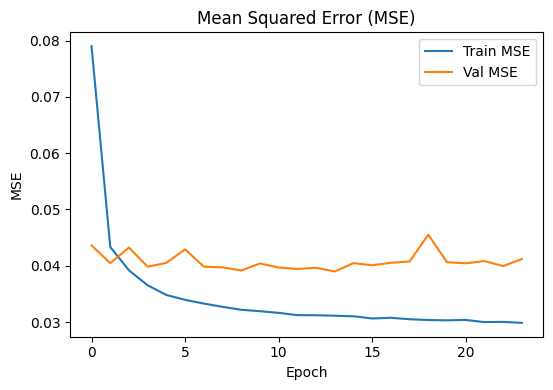


Score

--- Skor Akhir Model ---
Loss: 0.15599
Compile_metrics: 0.03915


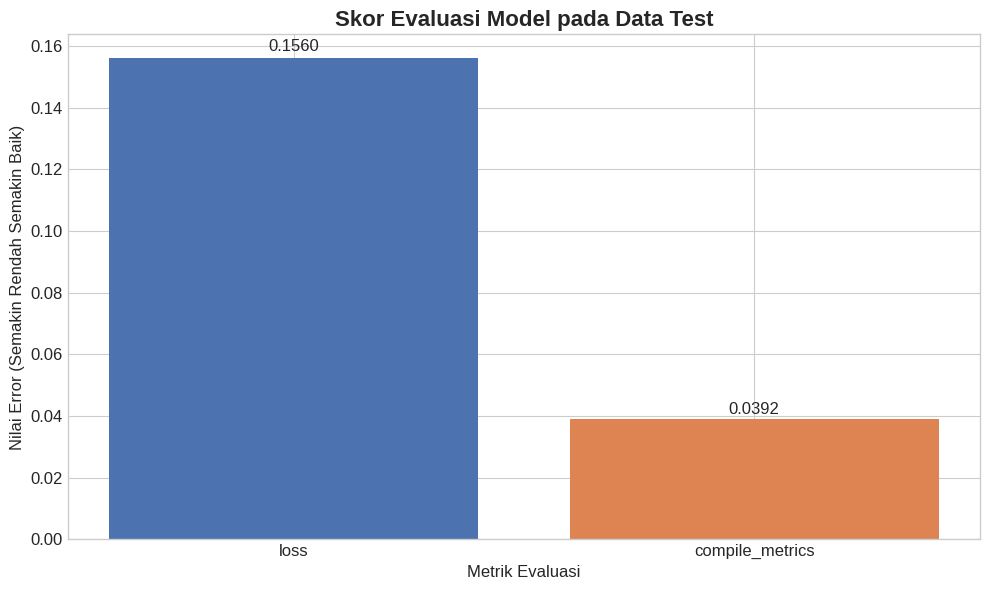

{'loss': 0.15598905086517334, 'compile_metrics': 0.03915395960211754}

In [ ]:
print("Kurva\n")
plot_training_history(history_final.history)

print("\nScore")
evaluate_and_plot_metrics(final_model, X_test, y_test)

**Kurva:**
-  Garis Train MSE (biru) yang terus menurun menunjukkan bahwa model berhasil mempelajari pola dari data training.
-  Garis Val MSE (oranye), Awalnya, garis ini ikut turun, yang berarti model mampu menggeneralisasi pengetahuannya. Namun, setelah sekitar epoch 8, garis ini mendatar di sekitar nilai error 0.04. Ini artinya, model tidak lagi menjadi lebih baik dalam memprediksi data baru.
- Celah yang mulai melebar antara garis biru (Train MSE) dan oranye (Val MSE) adalah gejala overfitting ringan yang umum terjadi saat model mulai terlalu menghafal data training. Namun, hal ini tidak menjadi masalah yang signifikan karena proses training dihentikan secara di epoch ke-23, tepat ketika performa model pada data validasi sudah tidak menunjukkan perbaikan. Langkah ini memastikan model tidak terus belajar ke arah yang salah dan performanya pada data baru tidak memburuk.

**Score:**
- Loss 0.1560. Secara rata-rata, prediksi yang diberikan model meleset sekitar 0.1560 dari nilai yang seharusnya.
- compile metrics  0.0392. model cukup stabil

**Kesimpulan:**

model prediksi kualitas udara ini dapat disimpulkan berhasil dikembangkan dengan baik dan menunjukkan performa yang cukup baik

Proses pelatihan berjalan efektif, di mana model mampu mempelajari pola data secara signifikan. Gejala overfitting ringan yang wajar terjadi berhasil ditangani secara tepat dengan menghentikan training pada epoch ke-23. Langkah ini krusial untuk menjaga kemampuan model dalam menggeneralisasi data baru dan mencegah performanya memburuk.

Pada akhirnya, model memberikan performa yang stabil dan andal saat diuji pada data yang belum pernah dilihat sebelumnya. Hal ini dibuktikan dengan skor Mean Squared Error (MSE) sebesar 0.0392 yang sangat konsisten dengan hasil selama validasi. Sementara itu, skor Mean Absolute Error (MAE) sebesar 0.1560 memberikan ukuran yang jelas mengenai rata-rata kesalahan prediksi model.

# Deploy

In [ ]:
import tensorflow as tf
import joblib

# Simpan scaler
joblib.dump(scaler, 'minmax_scaler.pkl')
print("Scaler berhasil dilatih dan disimpan!")

Scaler berhasil dilatih dan disimpan!


In [ ]:
# Muat model
model = tf.keras.models.load_model('model.keras')
scaler = joblib.load('minmax_scaler.pkl')

In [ ]:
stasiun_kolom_ohe = [
    'stasiun_DKI 1 : Bundaran HI', 'stasiun_DKI 2 : Kelapa Gading', 'stasiun_DKI 4 : Lubang Buaya',
    'stasiun_DKI 3 : Jagakarsa',
    'stasiun_DKI 5 : Kebon Jeruk']
kolom_model_lengkap = kolom_polutan + stasiun_kolom_ohe
input_window = 30
output_window = 15
#Kolom tanggl adalah index yang dah diurutkan
df_combined = df_combined.set_index('tanggal').sort_index()

In [ ]:
def generate_future_predictions(model, scaler, last_30_days_data, all_model_columns, station_columns, pollutan_columns, input_win=30):
    all_predictions = {}

    # Cetak daftar stasiun yang diterima oleh fungsi
    print(f"\nFungsi menerima {len(station_columns)} stasiun untuk diproses.")

    for station_ohe_name in station_columns:
        # === MULAI BLOK TRY-EXCEPT ===
        try:
            print(f"\n--- Memulai proses untuk stasiun: {station_ohe_name} ---")

            # 1. Buat DataFrame input
            input_df = pd.DataFrame(columns=all_model_columns)
            input_df[pollutan_columns] = last_30_days_data.values
            for col in station_columns:
                input_df[col] = 0
            input_df[station_ohe_name] = 1
            input_df.fillna(0, inplace=True)
            print("Langkah 1: DataFrame input berhasil dibuat.")

            # 2. PREPROCESSING
            processed_input = input_df.copy()
            for col in pollutan_columns:
                if (processed_input[col] >= 0).all():
                    processed_input[col] = np.sqrt(processed_input[col])
            processed_input[pollutan_columns] = scaler.transform(processed_input[pollutan_columns])
            input_data_for_model = np.array([processed_input.values])
            print("Langkah 2: Preprocessing berhasil.")

            # 3. MELAKUKAN PREDIKSI
            predicted_normalized = model.predict(input_data_for_model)
            print("Langkah 3: Prediksi oleh model berhasil.")

            # 4. INVERSE TRANSFORM
            predicted_reshaped = predicted_normalized.reshape(-1, len(pollutan_columns))
            predicted_scaled_back = scaler.inverse_transform(predicted_reshaped)
            final_prediction = np.square(predicted_scaled_back)
            print("Langkah 4: Inverse transform berhasil.")

            # 5. FORMATTING OUTPUT
            future_dates = pd.to_datetime(last_30_days_data.index[-1]) + pd.to_timedelta(np.arange(1, 16), 'D')
            prediction_df = pd.DataFrame(final_prediction, columns=pollutan_columns, index=future_dates)
            station_name_clean = station_ohe_name.replace("stasiun_", "").strip()
            all_predictions[station_name_clean] = prediction_df
            print(f"--- SUKSES! Prediksi untuk {station_ohe_name} selesai dan disimpan. ---")

        # === BLOK INI AKAN MENANGKAP ERROR JIKA TERJADI ===
        except Exception as e:
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print(f"GAGAL MEMPROSES STASIUN: {station_ohe_name}")
            print(f"ERROR YANG TERJADI: {e}")
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            # Loop akan lanjut ke stasiun berikutnya
            continue

    print("\n--- Prediksi untuk semua stasiun selesai (atau dilewati jika error). ---")
    return all_predictions

In [ ]:
# Buat prediksi
# Ambil 30 data terakhir dengan satu stasiun 30 data terakhr
last_30_unique_days = df_combined.index.unique()[-30:]
last_30_days_data = df_combined[df_combined.index.isin(last_30_unique_days)]
# Karena satu hari bisa ada data dari 5 stasiun, kita cukup ambil rata-rata per hari sebagai basis input polutan.
last_30_days_avg_data = last_30_days_data.groupby(last_30_days_data.index)[kolom_polutan].mean()

# Panggil fungsi utama untuk menghasilkan prediksi
future_forecast = generate_future_predictions(
    model=model,
    scaler=scaler,
    last_30_days_data=last_30_days_avg_data, # Gunakan data rata-rata 30 hari terakhir
    all_model_columns=kolom_model_lengkap,
    station_columns=stasiun_kolom_ohe,
    pollutan_columns=kolom_polutan,
    input_win=input_window
)

# Tampilkan hasil prediksi untuk salah satu stasiun
print("\n--- Hasil Prediksi 15 Hari ke Depan (Skala Asli) ---")
for station, prediction_df in future_forecast.items():
    print(f"\nPrediksi untuk Stasiun: {station}")
    print(prediction_df.round(2))


Fungsi menerima 5 stasiun untuk diproses.

--- Memulai proses untuk stasiun: stasiun_DKI 1 : Bundaran HI ---
Langkah 1: DataFrame input berhasil dibuat.
Langkah 2: Preprocessing berhasil.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
Langkah 3: Prediksi oleh model berhasil.
Langkah 4: Inverse transform berhasil.
--- SUKSES! Prediksi untuk stasiun_DKI 1 : Bundaran HI selesai dan disimpan. ---

--- Memulai proses untuk stasiun: stasiun_DKI 2 : Kelapa Gading ---
Langkah 1: DataFrame input berhasil dibuat.
Langkah 2: Preprocessing berhasil.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Langkah 3: Prediksi oleh model berhasil.
Langkah 4: Inverse transform berhasil.
--- SUKSES! Prediksi untuk stasiun_DKI 2 : Kelapa Gading selesai dan disimpan. ---

--- Memulai proses untuk stasiun: stasiun_DKI 4 : Lubang Buaya ---
Langkah 1: DataFrame input berhasil dibuat.
Langkah 2: Preprocessing berhasil.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Langkah 3: Prediksi oleh model berhasil.
Langkah 4: Inverse transform berhasi

In [ ]:
""""Menyimpan file historis run jika diperlukan saja"""

import json
df_combined['tanggal'] = pd.to_datetime(df_combined['tanggal'])
df_combined.sort_values(by='tanggal', inplace=True)
tanggal_terakhir_data = df_combined['tanggal'].max()

with open('info_terakhir.json', 'w') as f:
  json.dump({'tanggal_terakhir': tanggal_terakhir_data.strftime('%Y-%m-%d')}, f)
print(f"Info tanggal terakhir ({tanggal_terakhir_data.strftime('%Y-%m-%d')}) disimpan ke info_terakhir.json")

bekal_data_list = []
list_stasiun_dki = df_combined['stasiun'].unique()

for stasiun in list_stasiun_dki:
    # Filter data untuk stasiun ini dan ambil 30 baris terakhir
    stasiun_df = df_combined[df_combined['stasiun'] == stasiun].tail(30)
    bekal_data_list.append(stasiun_df)

bekal_df_final = pd.concat(bekal_data_list)

bekal_df_final.to_csv('historis_for_data_prediksi.csv', index=False)
print("Bekal data (30 hari terakhir per stasiun) berhasil disimpan ke bekal_data_prediksi.csv")

Info tanggal terakhir (2025-03-31) disimpan ke info_terakhir.json
